    SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
118     22023  1610612745               HOU        Houston Rockets   
120     22023  1610612755               PHI     Philadelphia 76ers   
121     22023  1610612747               LAL     Los Angeles Lakers   
122     22023  1610612760               OKC  Oklahoma City Thunder   
123     22023  1610612759               SAS      San Antonio Spurs   

        GAME_ID   GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  \
118  1522300076  2023-07-17    HOU @ CLE  L  198   78  ...   0.643     9   
120  1522300068  2023-07-16    PHI @ NOP  W  201  117  ...   0.722    12   
121  1522300075  2023-07-16    LAL @ LAC  W  201  104  ...   0.611    12   
122  1522300072  2023-07-16    OKC @ SAS  L  200   94  ...   0.773     6   
123  1522300072  2023-07-16  SAS vs. OKC  W  199   98  ...   0.833    15   

     DREB  REB  AST  STL  BLK  TOV  PF  PLUS_MINUS  
118    28   37   15    7    1   13  18       -23.6  
120    21   33  

C:\Users\ghadf\AppData\Local\Temp\ipykernel_24612\2755948011.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))
C:\Users\ghadf\AppData\Local\Temp\ipykernel_24612\2755948011.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
C:\Users\ghadf\AppData\Local\Temp\ipykernel_24612\2755948011.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy

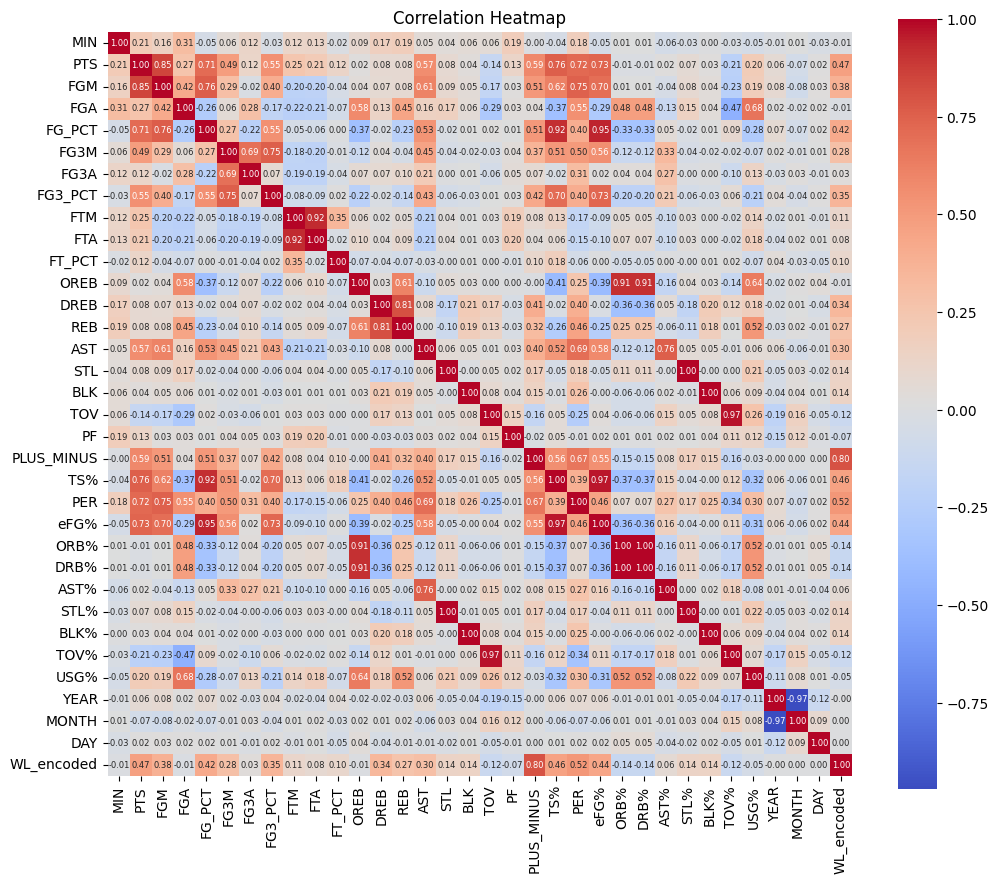

In [27]:
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

teams = teams.get_teams()
#print(teams)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)
print(data.head())
#stat addons list: PER, TS%, eFG%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP
#adding TS%= PTS / (2 * (FGA + 0.44 * FTA))
data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))

#adding PER
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])

#adding eFG%
data['eFG%'] = (data['FGM'] + 0.5 * data['FG3M']) / data['FGA']

#adding ORB%
data['ORB%'] = data['OREB'] / (data['OREB'] + data['DREB'])

#adding DRB%
data['DRB%'] = data['OREB'] / (data['OREB'] + data['DREB'])

#adding TRB% ***not sure if this is correct, it's not working
#data['TRB%'] = (data['OREB'] + data['DREB']) / data['REB']

#adding AST%
data['AST%'] = data['AST'] / data['FGM']

#adding STL%
data['STL%'] = data['STL'] / data['MIN']

#adding BLK%
data['BLK%'] = data['BLK'] / data['MIN']

#adding TOV%
data['TOV%'] = data['TOV'] / (data['FGA'] + 0.44 * data['FTA'] + data['TOV'])

#adding USG%
data['USG%'] = (data['FGA'] + 0.44 * data['FTA'] + data['TOV']) / data['MIN']

#adding OWS
#adding DWS
#adding WS
3#adding WS/48
#adding OBPM
#adding DBPM
#adding BPM
#adding VORP
#adding O/D Rating
#adding O/D Win Shares
#adding O/D Win Shares
#adding O/D WS/48
#adding O/D BPM
#adding O/D BPM
#adding O/D VORP
#adding O/D VORP

#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Convert all non-numeric values in a column
# Encode non-numeric values in the 'TEAM_ID' column as categorical variables
data_encoded = pd.get_dummies(data, columns=['TEAM_ID'], prefix='TEAM')


#**Drop Missing values
# Drop rows with missing values
data_encoded = data_encoded.dropna()

# Filter the data to include only selected columns
data_encoded_selected = data_encoded.iloc[:, :40]


# Check the updated column names in the DataFrame
print('encoded_data = ',data_encoded_selected.columns)
#print(data_encoded_selected)

# Filter the data for the 2022-2023 NBA season
#could also use season_id = 42022
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded_selected[(data_encoded_selected['GAME_DATE'] >= start_date) & (data_encoded_selected['GAME_DATE'] <= end_date)].copy()

# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data.head())


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
season_data = season_data[[col for col in season_data.columns if col != 'WL_encoded'] + ['WL_encoded']]

# Create a correlation matrix for the selected columns
correlation_matrix = season_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 6})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

#In this code, we reorder the columns of season_data so that the target variable 'WL_encoded' is at the end. 
# Then, we calculate the correlation matrix using season_data.corr() and plot the heatmap using sns.heatmap(). 
# The heatmap will show the correlation values between different variables, with positive correlations in warmer colors and negative 
# correlations in cooler colors. The annot=True parameter shows the actual correlation values on the heatmap, and fmt='.2f' formats 
# the numbers to two decimal places. The cmap='coolwarm' parameter sets the color scheme for the heatmap.


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'

# Update season_data with encoded features
labelencoder = LabelEncoder()
season_data['TEAM_NAME'] = labelencoder.fit_transform(season_data['TEAM_NAME'])
season_data['MATCHUP'] = labelencoder.fit_transform(season_data['MATCHUP'])

# Drop any rows with missing values from season_data
season_data.dropna(inplace=True)

# Define X and y using the updated season_data DataFrame
X = season_data.drop(columns=[y_column,'GAME_DATE','TEAM_ABBREVIATION','WL','ORB%','DRB%','FGA','TOV','TOV%','USG%','FG3A','OREB','PF'])
y = season_data[y_column]

print(X) #checking on the columns to ensure coded and the length is long enough for the season/playoffs

# Confirm the shape of X and y after handling missing values and encoding
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)




     SEASON_ID  TEAM_NAME     GAME_ID  MATCHUP  MIN  PTS  FGM  FG_PCT  FG3M  \
652      42022         14  0042200405      819  240   89   33   0.344     9   
653      42022          6  0042200405      391  240   94   38   0.452     5   
669      42022          6  0042200404      362  242  108   39   0.494    14   
677      42022         14  0042200404      848  240   95   35   0.449     8   
696      42022          6  0042200403      362  238  109   41   0.513     5   
...        ...        ...         ...      ...  ...  ...  ...     ...   ...   
8242     12022         26  0012200006     1568  242  114   42   0.483    12   
8243     12022          1  0012200005      147  239  134   48   0.571    22   
8244     12022         28  0012200004     1637  240   95   30   0.353     8   
8245     12022         15  0012200003      913  240  102   37   0.430    13   
8246     12022         13  0012200003      769  239  107   38   0.494    10   

      FG3_PCT  ...  PLUS_MINUS       TS%  PER      

In [31]:
from sklearn.metrics import mean_squared_error, r2_score
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Get the team names from the original dataset for the test set
team_names_test = season_data.loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)
game_ids_test = season_data.loc[X_test.index, 'GAME_ID'].reset_index(drop=True)

# Create a DataFrame with team names and predicted probabilities for linear regression
probabilities_df_lr = pd.DataFrame({'GAME_ID': game_ids_test,'TEAM_NAME': team_names_test, 'Probability': y_pred_lr})

# Remove duplicates from df1 based on 'player_name' column
team_abbrev_unique = season_data.drop_duplicates(subset='TEAM_ABBREVIATION')

# Perform the merge between probabilities_df_lr and team_abbrev_unique to add abbreviations
probabilities_df_lr = probabilities_df_lr.merge(team_abbrev_unique[['TEAM_NAME', 'TEAM_ABBREVIATION']], on='TEAM_NAME', how='left')

# Remove duplicates from df1 based on 'player_name' column
game_matchups = data_encoded_selected.drop_duplicates(subset='GAME_ID')

# Perform the merge between probabilities_df_lr and game_matchups to add matchups
probabilities_df_lr = probabilities_df_lr.merge(game_matchups[['GAME_ID', 'MATCHUP','GAME_DATE']], on='GAME_ID', how='left')

# Map probabilities to binary outcomes (W or L) based on a threshold of 0.5
probabilities_df_lr['Prediction'] = probabilities_df_lr['Probability'].apply(lambda x: 'W' if x >= 0.5 else 'L')

# Reset the index of probabilities_df_lr for proper display
probabilities_df_lr.reset_index(drop=True, inplace=True)

# Sort the DataFrame by probabilities in descending order for linear regression
probabilities_df_lr = probabilities_df_lr.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for linear regression
print("Linear Regression Predictions:")
print(probabilities_df_lr)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"LR R-squared: {r2_lr:.2f}")
print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

Linear Regression Predictions:
        GAME_ID  TEAM_NAME  Probability TEAM_ABBREVIATION      MATCHUP  \
490  0012200027         23     2.310337               POR  POR vs. MRA   
466  0012200038         19     1.828713               OKC  OKC vs. MRA   
354  0022200034          5     1.730993               DAL    MEM @ DAL   
168  0022200123          2     1.678634               BKN    BKN @ WAS   
188  0022200114         26     1.666243               TOR    TOR @ SAS   
..          ...        ...          ...               ...          ...   
419  0012200070         12    -0.683815               LAL    LAL @ SAC   
345  0022200034         13    -0.690201               MEM    MEM @ DAL   
169  0022200123         28    -0.707515               WAS    BKN @ WAS   
199  0022200114         25    -0.731993               SAS    TOR @ SAS   
530  0012200005          3    -0.734197               CHA    CHA @ BOS   

     GAME_DATE Prediction  
490 2022-10-06          W  
466 2022-10-09          

In [32]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test)

# Predict using the Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test)

# Predict using the Random Forest model
y_pred_rf = rf_model.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)

# Calculate metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1-score:", svm_f1)
print("SVM Confusion Matrix:")
print(svm_confusion_matrix)

print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Precision:", logreg_precision)
print("Logistic Regression Recall:", logreg_recall)
print("Logistic Regression F1-score:", logreg_f1)
print("Logistic Regression Confusion Matrix:")
print(logreg_confusion_matrix)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-score:", rf_f1)
print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)


SVM Accuracy: 0.49906890130353815
SVM Precision: 0.0
SVM Recall: 0.0
SVM F1-score: 0.0
SVM Confusion Matrix:
[[268   0]
 [269   0]]
Logistic Regression Accuracy: 0.49906890130353815
Logistic Regression Precision: 0.0
Logistic Regression Recall: 0.0
Logistic Regression F1-score: 0.0
Logistic Regression Confusion Matrix:
[[268   0]
 [269   0]]
Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1-score: 1.0
Random Forest Confusion Matrix:
[[268   0]
 [  0 269]]


c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier with desired hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics for the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-score:", rf_f1)
print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)


Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1-score: 1.0
Random Forest Confusion Matrix:
[[284   0]
 [  0 253]]


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have already prepared the X (features) and y (target) data
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier model and fit it to the training data
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_gb = gb_model.predict(X_test)

# Calculate metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb)
gb_recall = recall_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb)
gb_confusion_matrix = confusion_matrix(y_test, y_pred_gb)

# Print the evaluation metrics
print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting Precision:", gb_precision)
print("Gradient Boosting Recall:", gb_recall)
print("Gradient Boosting F1-score:", gb_f1)
print("Gradient Boosting Confusion Matrix:")
print(gb_confusion_matrix)


Gradient Boosting Accuracy: 1.0
Gradient Boosting Precision: 1.0
Gradient Boosting Recall: 1.0
Gradient Boosting F1-score: 1.0
Gradient Boosting Confusion Matrix:
[[284   0]
 [  0 253]]
